In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from src.gaussian_mixture.gaussian_mixture import evaluate_case, find_best_component_number
from sklearn.cluster import MeanShift, estimate_bandwidth
from src.utils.dataset import *
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from lifelines.utils import concordance_index
from sklearn import metrics
import tensorflow.keras.datasets.reuters
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
def prepare_reuters_dataset():
    (sequences, target), _ = tensorflow.keras.datasets.reuters.load_data(
        num_words=1000,
        test_split=0,
        seed=113,
        start_char=1,
        oov_char=2,
        index_from=3
    )
    categories = np.unique(target)
    categories = sorted(categories, key=lambda category: -np.sum(target == category))
    categories = categories[:5]
    print("Categories:", [np.sum(target == i) for i in categories])
    mask = [label in categories for label in target]
    sequences = sequences[mask].copy()
    target = target[mask].copy()
    print("Total count", len(target))
    return sequences, target

sequences, target = prepare_reuters_dataset()

Categories: [3972, 2423, 682, 543, 537]
Total count 8157


In [3]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_sequences(sequences)
vectors = tokenizer.sequences_to_matrix(sequences, mode='tfidf')

vectors.shape

(8157, 1000)

In [8]:
def reduce_to_2d_for_visualization(vectors):
    return PCA(n_components=2).fit_transform(vectors)

dim2 = reduce_to_2d_for_visualization(vectors)

dim2.shape

(8157, 2)

In [9]:
def visualize_2d(data, labels):
    ax = plt.figure(figsize=(10,10)).add_subplot(1,1,1)
    for label in np.unique(labels):
        ax.scatter(data[labels == label, 0], data[labels == label, 1], label=label, cmap='tab20')
    ax.legend()
    plt.show()

In [10]:
def calculate_clustering_metrics(labels_true, labels_pred):
    metrics_to_evaluate_1 = {
        'c_index': concordance_index,
        'homogeneity': metrics.homogeneity_score,
        'completeness': metrics.completeness_score,
        'v_measure': metrics.v_measure_score,
        'normalized_mutual_info': metrics.normalized_mutual_info_score,
    }

    metrics_to_evaluate_2 = {
        'silhouette': metrics.silhouette_score,
        'davies_bouldin': metrics.davies_bouldin_score,
    }

    p1 = {
        metric_name: metric(labels_true, labels_pred) for
        metric_name, metric in
        metrics_to_evaluate_1.items()
    }
    p2 = {
        metric_name: metric(labels_true.reshape((-1,1)), labels_pred.reshape((-1,1))) for
        metric_name, metric in
        metrics_to_evaluate_2.items()
    }

    p1.update(p2)

    return p1

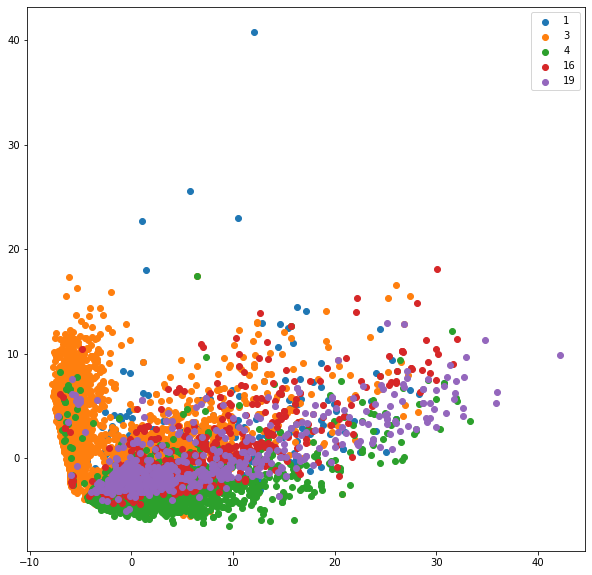

In [11]:
visualize_2d(dim2, target)

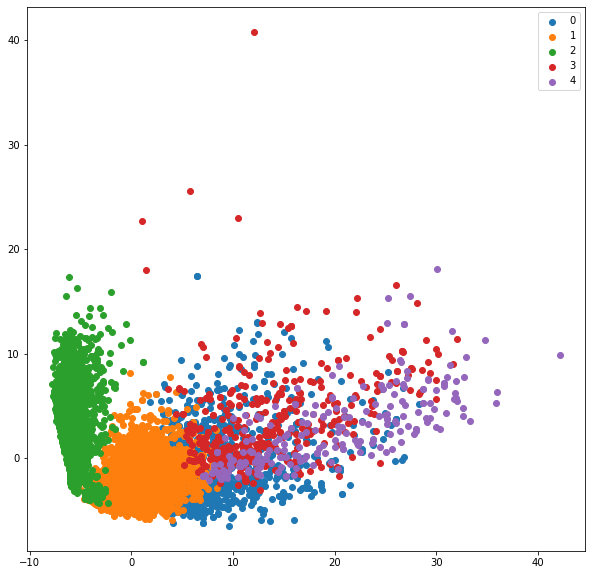

{'c_index': 0.37282822855912945,
 'homogeneity': 0.34318399581225617,
 'completeness': 0.36616571017628025,
 'v_measure': 0.35430256892151063,
 'normalized_mutual_info': 0.35430256892151063,
 'silhouette': -0.05761841246030862,
 'davies_bouldin': 2.6996712918918204}

In [12]:
predicted = GaussianMixture(n_components=5).fit_predict(vectors)
visualize_2d(dim2, predicted)
calculate_clustering_metrics(target, predicted)